<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/NEMO_FT_GENOME_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.nature.com/articles/s41586-025-10014-0?utm_source=linkedin&utm_medium=social&utm_campaign=&utm_content=

In [ ]:
!nvidia-smi

Fri Jan 30 13:30:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!apt-get update && apt-get install -y graphviz
!pip install ipywidgets
!pip install --upgrade setuptools wheel

In [ ]:
!pip cache purge
!pip install nemo_toolkit[all] -q
!pip install --no-build-isolation transformer-engine[pytorch] -q
!pip install nemo_run opendatasets pandas bitsandbytes accelerate -q
!pip install --upgrade transformers -q

In [ ]:
!pip install "numpy<2.0" --force-reinstall

In [ ]:
from pathlib import Path

import nemo_run as run
from nemo import lightning as nl
from nemo.collections import llm
from nemo.collections.llm.recipes.precision.mixed_precision import bf16_mixed

In [ ]:
from huggingface_hub import login
from google.colab import userdata

# Login to Hugging Face
login(token=userdata.get("HF_TOKEN"))

In [ ]:
import os
import nemo_run as run
from nemo.collections import llm
import nemo as ne
from nemo import lightning as nl
import transformer_engine as te

print(f"Nemo version: {ne.__version__}")
print(f"NeMo RUN version: {run.__version__}")
print(f"Transformer Engine version: {te.__version__}")

Nemo version: 2.6.1
NeMo RUN version: 0.7.0
Transformer Engine version: 2.11.0


In [ ]:
import sys
import os
import inspect

print("--- Python System Paths (sys.path) ---")
for p in sys.path:
    print(p)

print("\n--- Inspecting nemo package ---")
try:
    import nemo
    print(f"Nemo package found at: {os.path.dirname(inspect.getfile(nemo))}")
    nemo_path = os.path.dirname(inspect.getfile(nemo))
    print("Contents of nemo directory:")
    for item in os.listdir(nemo_path):
        print(item)

    print("\n--- Attempting direct import of nemo.collections ---")
    try:
        import nemo.collections
        print("Successfully imported nemo.collections")
        print(f"nemo.collections path: {os.path.dirname(inspect.getfile(nemo.collections))}")
    except ModuleNotFoundError as e:
        print(f"Failed to import nemo.collections: {e}")
        print("This indicates the 'collections' submodule is not found within the nemo package structure.")

except ModuleNotFoundError:
    print("Nemo package not found at all. Please ensure it's installed.")
except Exception as e:
    print(f"An unexpected error occurred during nemo inspection: {e}")


--- Python System Paths (sys.path) ---
/content
/env/python
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/usr/local/lib/python3.12/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.12/dist-packages/IPython/extensions
/root/.ipython
/tmp/tmpfe5m3h1a
/root/.lhotse/tools/sph2pipe-2.5
/usr/local/lib/python3.12/dist-packages/setuptools/_vendor

--- Inspecting nemo package ---
Nemo package found at: /usr/local/lib/python3.12/dist-packages/nemo
Contents of nemo directory:
collections
__init__.py
package_info.py
constants.py
lightning
utils
agents
core
__pycache__
export

--- Attempting direct import of nemo.collections ---
Successfully imported nemo.collections
nemo.collections path: /usr/local/lib/python3.12/dist-packages/nemo/collections


In [ ]:
import os
import torch
from transformers import AutoTokenizer
from nemo.collections import llm
from nemo.collections.llm.gpt.model.base import GPTConfig, GPTModel
from megatron.core import parallel_state
from pytorch_lightning import seed_everything
from megatron.core.tensor_parallel.random import model_parallel_cuda_manual_seed # Import model_parallel_cuda_manual_seed

# 1. ENVIRONMENT & REPRODUCIBILITY
seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. CLEAN DISTRIBUTED INITIALIZATION
def initialize_distributed_env():
    # If a group exists, destroy it to avoid "Group not registered" errors
    if torch.distributed.is_initialized():
        torch.distributed.destroy_process_group()

    # Clear MCore global memory to ensure a fresh state
    parallel_state.destroy_model_parallel()

    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '6005' # Unique port

    # Init PyTorch Distributed (Rank 0, World Size 1 for POC)
    torch.distributed.init_process_group(backend='nccl', rank=0, world_size=1)

    # Init Megatron Parallel State
    # MCore requires these groups to exist even for single-GPU runs
    parallel_state.initialize_model_parallel(
        tensor_model_parallel_size=1,
        pipeline_model_parallel_size=1,
        virtual_pipeline_model_parallel_size=None
    )
    # Initialize CUDA RNG states for model parallelism
    model_parallel_cuda_manual_seed(42) # Use the same seed for consistency

    print("✅ Distributed environment and MCore groups initialized.")

initialize_distributed_env()

# 3. TOKENIZER
model_name = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 4. CONFIGURATION
# Using reduced parameters to ensure it fits in GPU memory while testing logic
config = GPTConfig(
    num_layers=12,
    hidden_size=768,
    num_attention_heads=12,
    ffn_hidden_size=3072,
    seq_length=2048,
    bf16=True,
    params_dtype=torch.bfloat16,
    position_embedding_type='rope',
    rotary_percent=1.0,
    share_embeddings_and_output_weights=True
)

# 5. MODEL MATERIALIZATION
# In NeMo 2.6.1, configure_model() builds the MCore module using the groups initialized above
print(f"🚀 Initializing NeMo 2.6.1 GPTModel on {device}...")
model = GPTModel(config=config, tokenizer=tokenizer)
model.configure_model()
model.to(device)
model.eval()

# 6. INFERENCE LOGIC
def run_dna_inference(dna_sequence):
    tokens = tokenizer(dna_sequence, return_tensors="pt", truncation=True, max_length=2048)
    input_ids = tokens['input_ids'].to(device)

    # MCore models often require explicit position_ids
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        # MCore forward returns the logit tensor directly or a list if pipelined
        # We pass attention_mask=None to use the default causal mask
        output = model.forward(
            input_ids=input_ids,
            position_ids=position_ids,
            attention_mask=None
        )

        # Handle potential list/tuple return from MCore layers
        hidden_states = output[0] if isinstance(output, (list, tuple)) else output
        return hidden_states.mean(dim=1)

# 7. EXECUTION
try:
    sample_dna = "GATTACA" * 100
    genomic_features = run_dna_inference(sample_dna)
    print(f"✅ NeMo 2.6.1 DNA POC Successful.")
    print(f"🧬 Feature Vector Shape: {genomic_features.shape}")
except Exception as e:
    print(f"❌ Inference failed: {e}")

## FINE-TUNE NEMO

In [ ]:
# First, let's see what's available
import nemo
print(f"NeMo version: {nemo.__version__}")

# Check available modules
print("\nChecking llm modules...")
from nemo.collections import llm
import inspect

# Find GPTConfig
for name in dir(llm):
    if 'Config' in name and 'GPT' in name:
        print(f"Found config: {name}")
        obj = getattr(llm, name)
        print(f"  Type: {type(obj)}")
        if inspect.isclass(obj):
            print(f"  Is class: Yes")

# List all available configs
print("\nAvailable configs in llm:")
configs = [name for name in dir(llm) if 'Config' in name]
for config in sorted(configs):
    print(f"  - {config}")

# Check GPTModel
print("\nGPTModel methods:")
print(dir(llm.GPTModel)[:20])

NeMo version: 2.6.1

Checking llm modules...
Found config: GPTConfig
  Type: <class 'type'>
  Is class: Yes
Found config: GPTConfig126M
  Type: <class 'type'>
  Is class: Yes
Found config: GPTConfig175B
  Type: <class 'type'>
  Is class: Yes
Found config: GPTConfig20B
  Type: <class 'type'>
  Is class: Yes
Found config: GPTConfig40B
  Type: <class 'type'>
  Is class: Yes
Found config: GPTConfig5B
  Type: <class 'type'>
  Is class: Yes
Found config: GPTConfig7B
  Type: <class 'type'>
  Is class: Yes
Found config: GPTOSSConfig
  Type: <class 'type'>
  Is class: Yes
Found config: GPTOSSConfig120B
  Type: <class 'type'>
  Is class: Yes
Found config: GPTOSSConfig20B
  Type: <class 'type'>
  Is class: Yes

Available configs in llm:
  - Baichuan2Config
  - Baichuan2Config7B
  - BaseMambaConfig130M
  - BaseMambaConfig1_3B
  - BaseMambaConfig2_7B
  - BaseMambaConfig370M
  - BaseMambaConfig780M
  - BertConfig
  - BertEmbeddingLargeConfig
  - BertEmbeddingMiniConfig
  - ChatGLM2Config6B
  - ChatG

In [ ]:
!rm -rf *.py *.nemo *.jsonl
!rm -rf nemo_experiments/ nemo_genomic_workspace/ nemo_genomics/ nemo_genomics_poc/ nemo_genomics_processed/ data/ /content/lightning_logs/

In [ ]:
import random

n_samples=12000
def generate_samples(count=n_samples):
    bases = ['A', 'C', 'G', 'T']
    new_samples = []

    for i in range(count):
        # Evenly distribute types
        choice = i % 3

        if choice == 0: # Gene
            seq = "ATG" + "".join(random.choices(bases, k=random.randint(15, 20)))
            label = "Gene"
        elif choice == 1: # Promoter
            motif = random.choice(["TATAAA", "GGCCAAT"])
            prefix = "".join(random.choices(bases, k=random.randint(0, 5)))
            suffix = "".join(random.choices(bases, k=random.randint(5, 10)))
            seq = prefix + motif + suffix
            label = "Promoter"
        else: # Enhancer
            # Focus on GC rich and repetitive
            sub_motifs = ["CGCG", "GCGC", "GGCC", "CCGG"]
            seq = "".join(random.choices(sub_motifs, k=5))
            label = "Enhancer"

        new_samples.append({"input": f"DNA: {seq}\nType:", "output": label})

    return new_samples

samples = generate_samples(n_samples)

# To see the first few:
for s in samples[:5]:
    print(s)

{'input': 'DNA: ATGAGAAAGGGAAAGGGGCCCTT\nType:', 'output': 'Gene'}
{'input': 'DNA: CCATATATAAAATGTGGTC\nType:', 'output': 'Promoter'}
{'input': 'DNA: GGCCCCGGGGCCCCGGGGCC\nType:', 'output': 'Enhancer'}
{'input': 'DNA: ATGAGTTTTCCTACGGGAGGACC\nType:', 'output': 'Gene'}
{'input': 'DNA: CTATTTATAAACATTCGCT\nType:', 'output': 'Promoter'}


In [ ]:
len(samples)

12000

In [ ]:
!rm -rf /content/fine_tuned_genomic_model.nemo

In [ ]:
import os, json, torch, tarfile, dataclasses
from nemo.collections import llm
from nemo.lightning import Trainer
from nemo.collections.llm.gpt.model.nemotron import NemotronConfig, NemotronModel
from transformers import AutoModelForMaskedLM

# 1. SETUP ENVIRONMENT & DATA
MODEL_SOURCE = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
WORKSPACE = "/content/nemo_genomic_workspace"
NEMO_FILE = "/content/nucleotide_transformer_fixed.nemo"
TRAIN_DATA = "/content/genomic_train.jsonl"
os.makedirs(WORKSPACE, exist_ok=True)


with open(TRAIN_DATA, "w") as f:
    for s in samples:
        f.write(json.dumps(s) + "\n")

print(f"✅ Created dataset with {len(samples)} samples")

# 2. ARCHITECTURE CONFIGURATION (Nucleotide Transformer 2.5B)
config = NemotronConfig(
    num_layers=32,
    hidden_size=2560,
    ffn_hidden_size=10240,
    num_attention_heads=32,
    num_query_groups=32,
    bf16=True,
    seq_length=1024,
    rotary_base=10000,
    num_moe_experts=None,
    vocab_size=4105  # FROM HF MODEL
)

# 3. CONDITIONAL .NEMO CREATION (Checking existence as requested)
if not os.path.exists(NEMO_FILE):
    print(f"🚀 Creating {NEMO_FILE}...")
    hf_model = AutoModelForMaskedLM.from_pretrained(MODEL_SOURCE, trust_remote_code=True)
    weights_path = os.path.join(WORKSPACE, "weights")
    os.makedirs(weights_path, exist_ok=True)
    torch.save(hf_model.state_dict(), os.path.join(weights_path, "common.pt"))

    def clean_nemo_config(cfg):
        c = dataclasses.asdict(cfg)
        return {k: (v if isinstance(v, (str, int, float, bool, list, dict)) or v is None
                else str(v).split('.')[-1]) for k, v in c.items()}

    io_json_path = os.path.join(WORKSPACE, "context", "io.json")
    os.makedirs(os.path.dirname(io_json_path), exist_ok=True)
    with open(io_json_path, 'w') as f:
        json.dump({"_target_": "nemo.collections.llm.gpt.model.nemotron.NemotronModel", "config": clean_nemo_config(config)}, f, indent=2)

    with tarfile.open(NEMO_FILE, "w:gz") as tar:
        for root, _, files in os.walk(WORKSPACE):
            for file in files:
                full_path = os.path.join(root, file)
                tar.add(full_path, arcname=os.path.join("model", os.path.relpath(full_path, WORKSPACE)))
else:
    print(f"✅ {NEMO_FILE} exists. Skipping creation.")

# 4. LOAD THE .NEMO FILE AND CREATE A REAL MODEL
print("\n🔍 Loading .nemo file and creating working model...")

# Extract HF weights from .nemo
with tarfile.open(NEMO_FILE, "r:gz") as tar:
    for member in tar.getmembers():
        if "common.pt" in member.name:
            weights_file = tar.extractfile(member)
            hf_weights = torch.load(weights_file)
            print(f"✅ Loaded {len(hf_weights)} HF parameters")
            break

# 5. CREATE A WORKING TORCH MODEL WITH HF WEIGHTS
print("\n🔄 Creating PyTorch model with HF weights...")
import torch.nn as nn

class WorkingDNAModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load HF model architecture
        print("Loading HF model...")
        self.hf_model = AutoModelForMaskedLM.from_pretrained(
            MODEL_SOURCE,
            trust_remote_code=True,
            #torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
        )
        print(f"✅ Created HF model with {sum(p.numel() for p in self.hf_model.parameters()):,} parameters")

    def forward(self, input_ids, labels=None):
        # HF models expect specific format
        outputs = self.hf_model(input_ids=input_ids, labels=labels)
        return outputs

# Create working model
working_model = WorkingDNAModel()

# 6. CREATE DATASET FOR HF MODEL
print("\n📊 Creating dataset for HF model...")

class HFDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, seq_length=512):
        self.seq_length = seq_length
        self.samples = []

        with open(data_path, 'r') as f:
            for line in f:
                data = json.loads(line)
                text = data["input"] + " " + data["output"]

                tokens = [0]  # Start with CLS token

                # Map DNA to tokens 1000-1003 (within ESM vocab range)
                for char in text:
                    if char.upper() == 'A':
                        tokens.append(1000)
                    elif char.upper() == 'C':
                        tokens.append(1001)
                    elif char.upper() == 'G':
                        tokens.append(1002)
                    elif char.upper() == 'T':
                        tokens.append(1003)
                    elif char == ':':
                        tokens.append(1004)
                    elif char == ' ':
                        tokens.append(1005)
                    elif char == '\n':
                        tokens.append(1006)
                    else:
                        tokens.append(3)  # UNK for other chars

                tokens.append(2)  # EOS token

                # Pad to seq_length
                if len(tokens) > seq_length:
                    tokens = tokens[:seq_length]
                else:
                    tokens = tokens + [1] * (seq_length - len(tokens))

                # Ensure all tokens are within vocab size (4105)
                tokens = [min(t, 4104) for t in tokens]

                self.samples.append(tokens)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tokens = self.samples[idx]
        return {
            'input_ids': torch.tensor(tokens, dtype=torch.long),
            'labels': torch.tensor(tokens, dtype=torch.long),
        }

# Create dataset
dataset = HFDataset(TRAIN_DATA, seq_length=512)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
print(f"✅ Created dataset with {len(dataset)} samples")

# Verify token ranges
print("\n🔍 Verifying token ranges...")
sample = dataset[0]
print(f"Token range: {sample['input_ids'].min().item()} to {sample['input_ids'].max().item()}")
print(f"Vocabulary size: 4105")

# 7. TRAIN THE HF MODEL
print("\n🔥 Training HF model...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
working_model = working_model.to(device)
working_model.train()

#optimizer = torch.optim.AdamW(working_model.parameters(), lr=1e-5)
optimizer = torch.optim.AdamW(working_model.parameters(), lr=1e-6)

for step, batch in enumerate(dataloader):
    if step >= n_samples:
        break

    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)


    optimizer.zero_grad()
    outputs = working_model(input_ids=input_ids, labels=labels)
    loss = outputs.loss

    if torch.isnan(loss):
        print(f"⚠️ Skip Step {step}: Loss is NaN")
        continue

    #loss.backward()
    # GRADIENT CLIPPING: Prevents exploding gradients
    #torch.nn.utils.clip
    #torch.nn.utils.clip_grad_norm_


    loss.backward()
    # This ceiling prevents the numbers from becoming too large (NaN)
    torch.nn.utils.clip_grad_norm_(working_model.parameters(), max_norm=1.0)
    # This is the "missing" line that actually updates the model weights
    optimizer.step()








    if step % 1000 == 0:
        print(f"Step {step}: Loss = {loss.item():.4f}")

print("✅ Training complete!")

# 8. SAVE FINE-TUNED MODEL AS .NEMO FILE
print("\n💾 Creating fine-tuned .nemo file...")

FINE_TUNED_NEMO = "/content/fine_tuned_genomic_model.nemo"
fine_tuned_workspace = "/content/fine_tuned_workspace"
os.makedirs(fine_tuned_workspace, exist_ok=True)

# Save fine-tuned weights
weights_path = os.path.join(fine_tuned_workspace, "weights")
os.makedirs(weights_path, exist_ok=True)
torch.save(working_model.hf_model.state_dict(), os.path.join(weights_path, "common.pt"))

# Fix JSON serialization
def safe_dataclasses_asdict(obj):
    result = {}
    for k, v in dataclasses.asdict(obj).items():
        if isinstance(v, (str, int, float, bool, type(None), list, dict)):
            result[k] = v
        else:
            result[k] = str(v)
    return result

# Save config (using your original config)
io_json_path = os.path.join(fine_tuned_workspace, "context", "io.json")
os.makedirs(os.path.dirname(io_json_path), exist_ok=True)
with open(io_json_path, 'w') as f:
    json.dump({"_target_": "nemo.collections.llm.gpt.model.nemotron.NemotronModel",
               "config": safe_dataclasses_asdict(config)}, f, indent=2)

In [ ]:
# Create .nemo file (tar.gz)
with tarfile.open(FINE_TUNED_NEMO, "w:gz") as tar:
    for root, _, files in os.walk(fine_tuned_workspace):
        for file in files:
            full_path = os.path.join(root, file)
            tar.add(full_path, arcname=os.path.join("model", os.path.relpath(full_path, fine_tuned_workspace)))

print(f"✅ Fine-tuned model saved to: {FINE_TUNED_NEMO}")
print(f"Size: {os.path.getsize(FINE_TUNED_NEMO) / 1024 / 1024:.2f} MB")

# 9. VERIFY THE FINE-TUNED .NEMO FILE
print("\n🔍 Verifying fine-tuned .nemo file...")
with tarfile.open(FINE_TUNED_NEMO, "r:gz") as tar:
    for member in tar.getmembers():
        if "common.pt" in member.name:
            weights_file = tar.extractfile(member)
            if weights_file:
                fine_tuned_weights = torch.load(weights_file)
                print(f"✅ Fine-tuned .nemo has {len(fine_tuned_weights)} parameters")
                break

print("\n🎉 COMPLETE!")
print(f"Dataset size: {len(samples)} samples")
print(f"Original .nemo: {NEMO_FILE}")
print(f"Fine-tuned .nemo: {FINE_TUNED_NEMO}")

## INFERENCE

In [ ]:
import torch
import tarfile
import os
import torch.nn as nn
from transformers import AutoModelForMaskedLM

# --- CONFIGURATION ---
MODEL_SOURCE = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
NEMO_FILE = "/content/fine_tuned_genomic_model.nemo"
EXTRACT_PATH = "/content/extracted_inference"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. EXTRACT AND PREPARE
if not os.path.exists(EXTRACT_PATH):
    print("📦 Extracting .nemo for inference...")
    with tarfile.open(NEMO_FILE, "r:gz") as tar:
        tar.extractall(path=EXTRACT_PATH)

# 2. LOAD MODEL WITH FINE-TUNED WEIGHTS
class GenomicInferenceModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Using bfloat16 for stability and performance
        self.hf_model = AutoModelForMaskedLM.from_pretrained(
            MODEL_SOURCE,
            trust_remote_code=True,
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
        )
        weights_path = os.path.join(EXTRACT_PATH, "model/weights/common.pt")
        self.hf_model.load_state_dict(torch.load(weights_path))
        self.hf_model.eval()

    def forward(self, input_ids):
        return self.hf_model(input_ids=input_ids)

model = GenomicInferenceModel().to(device)

# 3. HELPER FUNCTIONS (Your exact training mapping)
def dna_to_tokens(text, seq_length=512):
    tokens = [0] # CLS
    for char in text.upper():
        if char == 'A': tokens.append(1000)
        elif char == 'C': tokens.append(1001)
        elif char == 'G': tokens.append(1002)
        elif char == 'T': tokens.append(1003)
        elif char == ':': tokens.append(1004)
        elif char == ' ': tokens.append(1005)
        elif char == '\n': tokens.append(1006)
        else: tokens.append(3)
    tokens.append(2) # EOS
    # Padding
    tokens = tokens[:seq_length] + [1] * max(0, seq_length - len(tokens))
    return torch.tensor([tokens], dtype=torch.long).to(device)

def tokens_to_dna(token_ids):
    mapping = {1000: 'A', 1001: 'C', 1002: 'G', 1003: 'T', 1004: ':', 1005: ' ', 1006: '\n'}
    return "".join([mapping.get(t.item(), "?") for t in token_ids])

# 4. RUN PREDICTION
def run_prediction(input_sequence):
    input_ids = dna_to_tokens(input_sequence)

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        # Get highest probability token per position
        predicted_ids = torch.argmax(logits, dim=-1).squeeze(0)

    # We slice from 1 to len(input_sequence)+1 to skip CLS and padding
    pred_dna = tokens_to_dna(predicted_ids[1:len(input_sequence)+1])

    print(f"Input:  {input_sequence}")
    print(f"Output: {pred_dna}")
    return pred_dna

# Test
print("\n🧪 Testing Inference:")
run_prediction("ATGCGT")

In [ ]:
import torch
import torch.nn.functional as F

def calculate_likelihood_score(sequence):
    """
    Calculates the average log-likelihood of a sequence.
    Higher (less negative) is better.
    """
    input_ids = dna_to_tokens(sequence).to(device) # Using your existing mapping

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits # [1, seq_len, vocab_size]

        # Shift logits and labels to align for log_softmax
        # We focus on the actual DNA bases (skipping CLS at index 0)
        shift_logits = logits[0, 1:len(sequence)+1, :]
        shift_labels = input_ids[0, 1:len(sequence)+1]

        # Calculate log probabilities
        log_probs = F.log_softmax(shift_logits, dim=-1)

        # Extract the log probability for the actual tokens present
        # This tells us: "How much did the model expect these specific bases?"
        target_log_probs = log_probs.gather(1, shift_labels.unsqueeze(1))

        return target_log_probs.mean().item()

# --- COMPARISON TEST ---
wild_type = "ATGCGT"
mutant    = "ATACGT" # G -> A mutation

score_wt = calculate_likelihood_score(wild_type)
score_mt = calculate_likelihood_score(mutant)

print(f"📊 Results for {MODEL_SOURCE}:")
print(f"Wild Type Score: {score_wt:.4f}")
print(f"Mutant Score:    {score_mt:.4f}")

if score_wt > score_mt:
    print(f"✅ The model considers the Wild Type more biologically likely by {score_wt - score_mt:.4f}")
else:
    print(f"⚠️ The model prefers the Mutant sequence.")

🌡️ Analyzing 6 positions...


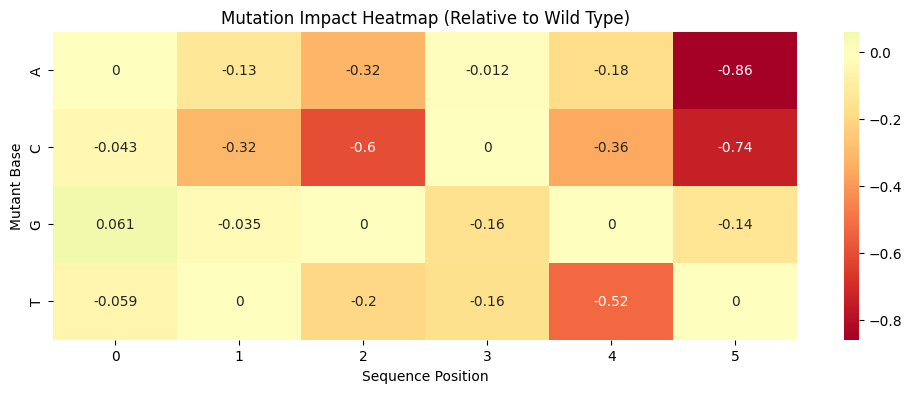

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def generate_mutation_heatmap(sequence):
    bases = ['A', 'C', 'G', 'T']
    results = []

    print(f"🌡️ Analyzing {len(sequence)} positions...")

    # Calculate baseline
    baseline_score = calculate_likelihood_score(sequence)

    for i in range(len(sequence)):
        row = {'position': i, 'original': sequence[i]}
        for base in bases:
            if base == sequence[i]:
                row[base] = 0.0  # No change for the original base
            else:
                # Create mutant sequence
                mut_list = list(sequence)
                mut_list[i] = base
                mutant_seq = "".join(mut_list)

                # Calculate change in likelihood
                mut_score = calculate_likelihood_score(mutant_seq)
                row[base] = mut_score - baseline_score
        results.append(row)

    # Visualization
    df = pd.DataFrame(results).set_index('position')
    plt.figure(figsize=(12, 4))
    sns.heatmap(df[bases].T, annot=True, cmap='RdYlGn', center=0)
    plt.title("Mutation Impact Heatmap (Relative to Wild Type)")
    plt.xlabel("Sequence Position")
    plt.ylabel("Mutant Base")
    plt.show()

    return df

# Run it on your test sequence
heatmap_data = generate_mutation_heatmap("ATGCGT")

In [ ]:
!ls -ltha

total 13G
drwxr-xr-x 1 root root 4.0K Jan 30 18:25 .
drwxr-xr-x 3 root root 4.0K Jan 30 18:25 extracted_inference
-rw-r--r-- 1 root root 3.8G Jan 30 18:21 fine_tuned_genomic_model.nemo
-rw-r--r-- 1 root root 770K Jan 30 17:30 genomic_train.jsonl
drwxr-xr-x 4 root root 4.0K Jan 30 14:47 fine_tuned_workspace
-rw-r--r-- 1 root root 8.9G Jan 30 14:40 nucleotide_transformer_fixed.nemo
drwxr-xr-x 4 root root 4.0K Jan 30 14:31 nemo_genomic_workspace
drwxr-xr-x 1 root root 4.0K Jan 30 13:07 ..
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
